In [1]:
## Import dependencies.
import itertools
from scipy.io import loadmat, savemat, matlab
import scipy.stats as stt
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

## Check whether simple_colors is installed, otherwise install using pip
try:
    from simple_colors import * # for printing colored and bold text
except:
    ! pip install simple_colors

## Import simple_colors
from simple_colors import *

## Flags.
sample_groupsize= 'matched' # Valid options: 'matched', 'all subjects'
# Flag 1
quick_optimize_flag = False
if quick_optimize_flag:
    epsilon_C = 0.001
else:
    epsilon_C = 0.0001
FC_scale = 'standard_scale' # Options: 'max_scale', 'standard_scale'
# Flag 2
io_based_on_nodal_degree_flag = False
# Flag 3
allow_all_connections_for_EC_flag = False
# Flag 4
optimize_with_FC_version = 'FC_scaled' # Options: 'FC_scaled','FC', 'ts_scaled'
# Flag 5
input_is_rowsum_flag = True # If == False, input = columnsum
# Flag 6
scale_ts_flag = True

## Introduce constants.
_FIGURES_DIR = 'subjectwise_inter_rc_analysis_figures'
_RES_DIR = str(
    'flag1-' + str(int(quick_optimize_flag)) +
    ' flag2-' + str(int(io_based_on_nodal_degree_flag)) +
    ' flag3-' + str(int(allow_all_connections_for_EC_flag)) +
    ' flag4-' + str(optimize_with_FC_version) +
    ' flag5-' + str(int(input_is_rowsum_flag)) +
    ' flag6-' + str(int(scale_ts_flag)) + '/')
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0
seed = 0 # None
print('The results of the analysis are stored in:', _RES_DIR)

The results of the analysis are stored in: flag1-0 flag2-0 flag3-0 flag4-FC_scaled flag5-1 flag6-1/


In [2]:
## Examine inter-periphery input and output.
def calculate_inter_periph_input_and_output(
    C, mask_inter_periph, input_is_rowsum=input_is_rowsum_flag):
    """This function is based on calculate_feeder_input_and_output().
    
    """

    if input_is_rowsum:
        input_axis = 0
        output_axis = 1
    else:
        input_axis = 1
        output_axis = 0

    inter_periph_C = np.copy(C)
    inter_periph_C[~mask_inter_periph] = 0
    if io_based_on_nodal_degree_flag:
        input_inter_periph = np.squeeze(np.count_nonzero(
            inter_periph_C, axis=input_axis, keepdims=True))
        output_inter_periph = np.squeeze(np.count_nonzero(
            inter_periph_C, axis=output_axis, keepdims=True))
    else:
        input_inter_periph = inter_periph_C[
            :, :].sum(axis=input_axis)
        output_inter_periph = inter_periph_C[
            :, :].sum(axis=output_axis)
    return input_inter_periph, output_inter_periph

In [3]:
## Examine inter-RC input and output.
def calculate_inter_rc_input_and_output(
    C, mask_inter_rc, input_is_rowsum=input_is_rowsum_flag):
    """This function is based on calculate_feeder_input_and_output().
    
    """

    if input_is_rowsum:
        input_axis = 0
        output_axis = 1
    else:
        input_axis = 1
        output_axis = 0

    inter_rc_C = np.copy(C)
    inter_rc_C[~mask_inter_rc] = 0
    if io_based_on_nodal_degree_flag:
        input_inter_rc= np.squeeze(np.count_nonzero(
            inter_rc_C, axis=input_axis, keepdims=True))
        output_inter_rc= np.squeeze(np.count_nonzero(
            inter_rc_C, axis=output_axis, keepdims=True))
    else:
        input_inter_rc= inter_rc_C[
            :, :].sum(axis=input_axis)
        output_inter_rc= inter_rc_C[
            :, :].sum(axis=output_axis)
    return input_inter_rc, output_inter_rc

In [4]:
def examine_significance(dist_patients, dist_controls, 
                         statistic_patients, statistic_controls,
                         statistic_description, y_labels, alpha, stat_fun):
    n_samples, n_subjects = group_samples.shape
    if sample_groupsize== 'matched':
        dist_patients = dist_patients[:n_subjects, :]
        dist_controls = dist_controls[:n_subjects, :]
        distribution = np.concatenate((dist_patients, dist_controls),
                                     axis=0)
    else:
        distribution = np.concatenate(
            (dist_patients, dist_controls), axis=0)    
    groups = np.array([distribution[group_sample.astype(int), :]
                                          for group_sample in group_samples])
    alpha = alpha # alpha percentile
    lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
    upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))
    rankordered_samples = np.sort(stat_fun(groups, axis=1), axis=0)
    rankordered_samples = rankordered_samples[lower_limit:upper_limit, :]
    xerr = rankordered_samples[[0,-1], :]

    fontsize = 15
    markersize = 18
    y = np.arange(xerr.shape[1])
    fig = plt.figure()
    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    for i_rc_roi in range(xerr.shape[1]):
        i_statistic_patients = statistic_patients[i_rc_roi]
        format_string = '.r'
        if (i_statistic_patients > xerr.T[i_rc_roi,1] or
            i_statistic_patients < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_patients, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
    plt.title(statistic_description + ' for patients',
              fontsize=title_fontsize)
    plt.show()

    fig = plt.figure()
    plt.hlines(np.matlib.repmat(y, 2, 1), xmin=xerr[0], xmax=xerr[1], color='b')
    plt.plot(xerr, np.matlib.repmat(y, 2, 1), '|', color='b', markersize=10)
    plt.plot(rankordered_samples.mean(axis=0), y, '|', color='b', markersize=5)
    for i_rc_roi in range(xerr.shape[1]):
        i_statistic_controls = statistic_controls[i_rc_roi]
        format_string = '.r'
        if (i_statistic_controls > xerr.T[i_rc_roi,1] or
            i_statistic_controls < xerr.T[i_rc_roi,0]):
            format_string = '.g' 
        plt.plot(i_statistic_controls, y_labels[i_rc_roi],
                 format_string, markersize=markersize)
    plt.title(statistic_description + ' for controls',
              fontsize=title_fontsize)
    plt.show()

In [5]:
#def plot_feeder_io_group_comparing_boxplot(input_patients, output_patients,
def plot_input_output_boxplot(input_patients, output_patients,
                              input_controls, output_controls, cmap):
    max_input = np.append(input_patients, input_controls).max()+1
    min_input = np.append(input_patients, input_controls).min()-1
    max_output = np.append(output_patients, output_controls).max()+1
    min_output = np.append(output_patients, output_controls).min()-1
    
    NUM_COLORS = max([len(input_Counter_subjects_total_patients),
                      len(input_Counter_subjects_total_controls),
                      len(input_Counter_subjects_total_controls),
                      len(output_Counter_subjects_total_patients)])
    cm = plt.get_cmap(cmap)
    
    plt.figure(figsize=(14, 10))
    plt.suptitle('Input', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    ax = plt.subplot(121)
    NUM_COLORS = len(input_Counter_subjects_total_patients)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    plt.xlim(min_input, max_input)
    n_rois = input_patients.shape[1]
    plt.boxplot(input_patients, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(input_patients[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(input_Counter_subjects_total_patients)]
    [plt.plot(input_patients[max_ind], np.arange(n_rois), markersize=10, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(input_Counter_subjects_total_patients)]
    plt.legend(title='subject index')
    ax = plt.subplot(122)
    NUM_COLORS = len(input_Counter_subjects_total_controls)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('input', fontsize=axis_lable_fontsize)
    plt.xlim(min_input, max_input)
    n_rois = input_controls.shape[1]
    plt.boxplot(input_controls, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(input_controls[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(input_Counter_subjects_total_controls)]
    [plt.plot(input_controls[max_ind], np.arange(n_rois), markersize=10, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(input_Counter_subjects_total_controls)]
    plt.legend(title='subject index')
    plt.show()
    plt.figure(figsize=(14, 10))
    plt.suptitle('Output', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    ax = plt.subplot(121)
    NUM_COLORS = len(output_Counter_subjects_total_patients)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Patient', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    plt.xlim(min_output, max_output)
    n_rois = output_patients.shape[1]
    plt.boxplot(output_patients, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(output_patients[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(output_Counter_subjects_total_patients)]
    [plt.plot(output_patients[max_ind], np.arange(n_rois), markersize=10, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(output_Counter_subjects_total_patients)]
    plt.legend(title='subject index')
    ax = plt.subplot(122)
    NUM_COLORS = len(output_Counter_subjects_total_controls)
    ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    plt.title('Control', fontsize=title_fontsize)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.xlabel('output', fontsize=axis_lable_fontsize)
    plt.xlim(min_output, max_output)
    n_rois = output_controls.shape[1]
    plt.boxplot(output_controls, positions = np.arange(n_rois), vert=False)
    
    #[plt.scatter(output_controls[max_ind], np.arange(n_rois), s=50, marker='o')
    # for max_ind in sorted(output_Counter_subjects_total_controls)]
    [plt.plot(output_controls[max_ind], np.arange(n_rois), markersize=10, 
              marker='o', linestyle='None', label=str(max_ind))
              for max_ind in sorted(output_Counter_subjects_total_controls)]
    plt.legend(title='subject index')
    plt.show()

In [6]:
## Examine io ratio of RC regions.
def plot_rc_io_ratio(io_ratio_rc_patients, io_ratio_rc_controls,
                     indexes_rc):
    plt.figure(figsize=(32, 10))
    plt.subplot(121)
    plt.title('Patients', fontsize=suptitle_fontsize)
    plt.subplots_adjust(top=top_adjust)
    n_rois = io_ratio_rc_patients.shape[1]
    plt.boxplot(io_ratio_rc_patients, positions = np.arange(n_rois),
                vert=False)
    plt.ylabel('region', fontsize=axis_lable_fontsize)
    plt.yticks(np.arange(n_rois), roi_labels[indexes_rc],
           fontsize=fontsize)
    plt.xlabel('io ratio', fontsize=axis_lable_fontsize)
    plt.subplot(122)
    plt.title('Controls', fontsize=suptitle_fontsize)
    n_rois = io_ratio_rc_controls.shape[1]
    plt.boxplot(io_ratio_rc_controls, positions = np.arange(n_rois),
                vert=False)
    plt.yticks(np.arange(n_rois), roi_labels[indexes_rc],
           fontsize=fontsize)
    plt.xlabel('io ratio', fontsize=axis_lable_fontsize)
    plt.show()

In [7]:
# Load EC per subject for patients & control group.
EC_patients_dict = np.load(_RES_DIR + 'EC_patients_dict.npy', allow_pickle=True).tolist()
EC_controls_dict = np.load(_RES_DIR + 'EC_controls_dict.npy', allow_pickle=True).tolist()
# Load parametes.
parameter_dict = np.load(_RES_DIR + 'parameter_dict.npy', allow_pickle=True).tolist()
roi_labels = parameter_dict['roi_labels']
mask_EC = parameter_dict['mask_EC']
group_samples = np.load(_RES_DIR + 'group_samples.npy')
J_patients = np.load(_RES_DIR + 'J_patients.npy')
J_controls = np.load(_RES_DIR + 'J_controls.npy')
Sigma_patients = np.load(_RES_DIR + 'Sigma_patients.npy')
Sigma_controls = np.load(_RES_DIR + 'Sigma_controls.npy')
dist_patients = np.load(_RES_DIR + 'dist_patients.npy')
dist_controls = np.load(_RES_DIR + 'dist_controls.npy')
R2_patients = np.load(_RES_DIR + 'R2_patients.npy')
R2_controls = np.load(_RES_DIR + 'R2_controls.npy')
EC_patients = EC_patients_dict['C_mod']
EC_controls = EC_controls_dict['C_mod']
print('epsilon_EC =', EC_patients_dict['epsilon_C'])

epsilon_EC = 0.0001


In [8]:
## Calculate the feeder input and output.
# Define constants.
n_patients, n_rois, _ = EC_patients.shape
n_controls, _, _ = EC_controls.shape
# Define RC.
rc_labels = ['precuneus', 'superiorfrontal', 'superiorparietal']
mask_rc = np.zeros(n_rois, dtype=bool)
for i_rc_label in rc_labels:
    mask_rc[np.frompyfunc(lambda x: i_rc_label in x, 1, 1)(roi_labels).astype(
        bool)] = True
indexes_rc = np.array(*np.where(mask_rc))
print(black('Rich club regions:\n', 'bold'), roi_labels[mask_rc].tolist())

# Create a 2D-mask for inter rich club connections.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
ind_combin_inter_rc= np.array(list(
    itertools.product(indexes_rc, repeat=2))).T
mask_inter_rc[ind_combin_inter_rc[0],
                      ind_combin_inter_rc[1]] = True
    # Set short inter-hemispheric connections to zero.
#    for i in range(int(n_rois/2)):
#        mask_inter_rc[i, int(n_rois/2)+i] = False
#        mask_inter_rc[int(n_rois/2)+i, i] = False

[input_patients, output_patients] = np.squeeze(np.split(
    np.array([ calculate_inter_rc_input_and_output(x, mask_inter_rc) 
              for x in EC_patients ]), 2, axis=1))

[input_controls, output_controls] = np.squeeze(np.split(
    np.array([ calculate_inter_rc_input_and_output(x, mask_inter_rc)
              for x in EC_controls ]), 2, axis=1))

Rich club regions:
 ['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']


RC-indexes:
 [23 26 27 57 60 61]
Investigate input and output regionwise for RC-periphery (feeder) connections:


No handles with labels found to put in legend.
No handles with labels found to put in legend.


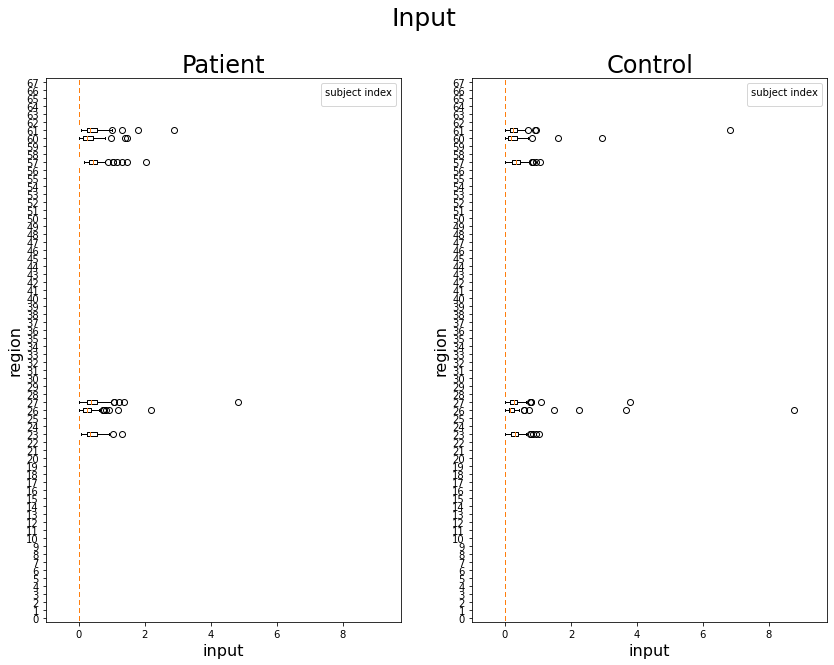

No handles with labels found to put in legend.
No handles with labels found to put in legend.


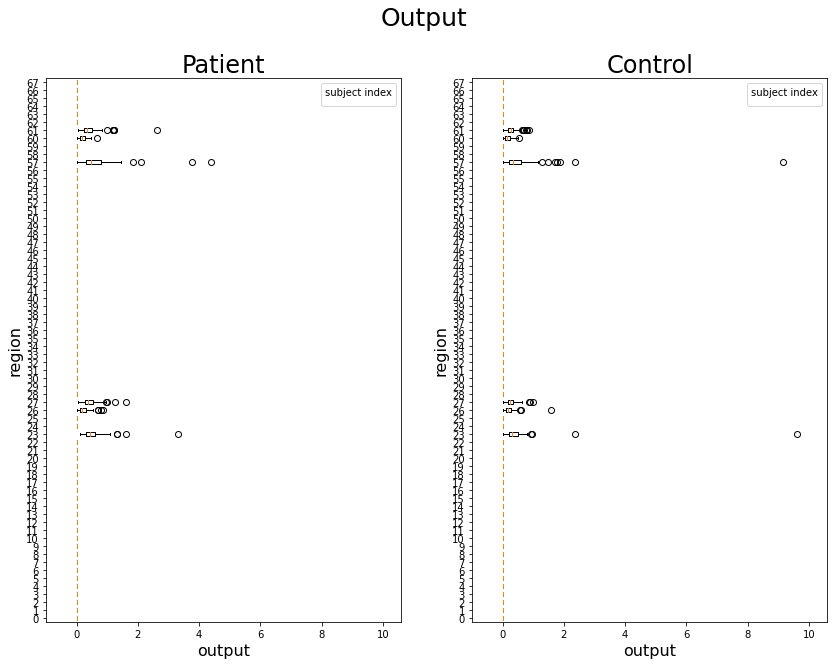

Mean rc input:	 0.0376220739640076 (patients)	 0.031233501604557967 (contols)


In [9]:
suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
fontsize = 15
top_adjust = 0.88
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(red('Investigate input and output regionwise for RC-periphery'
          ' (feeder) connections:', 'bold'))
#plot_feeder_io_boxplot(input_patients, output_patients, 'Patients')
#plot_feeder_io_boxplot(input_controls, output_controls, 'Controls')
input_Counter_subjects_total_patients = []
input_Counter_subjects_total_controls = []
output_Counter_subjects_total_patients = []
output_Counter_subjects_total_controls = []
plot_input_output_boxplot(
    input_patients, output_patients, input_controls, output_controls, 'jet')
print('Mean rc input:\t', input_patients.mean(),
  '(patients)\t', input_controls.mean(), '(contols)')

In [10]:
i_max = 0
with np.printoptions(threshold=np.inf):
    print(np.outer(np.sort(input_patients, axis=0)[-i_max-1, :], np.ones([n_patients])).shape)

max_values = np.outer(np.sort(input_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
max_values[max_values == 0] = -100
condition = input_patients.T == max_values

condition

(68, 60)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Input: Examine the subjects responsible for the largest value per region:
RC-indexes:
 [23 26 27 57 60 61]
Investigate input and output regionwise for RC-periphery (feeder) connections:
Patients:

input_Counter_subjects_total_patients:
 Counter({7: 3, 54: 1, 41: 1, 46: 1})

input_Counter_subjects_total_controls:
 Counter({38: 3, 8: 1, 61: 1, 33: 1})


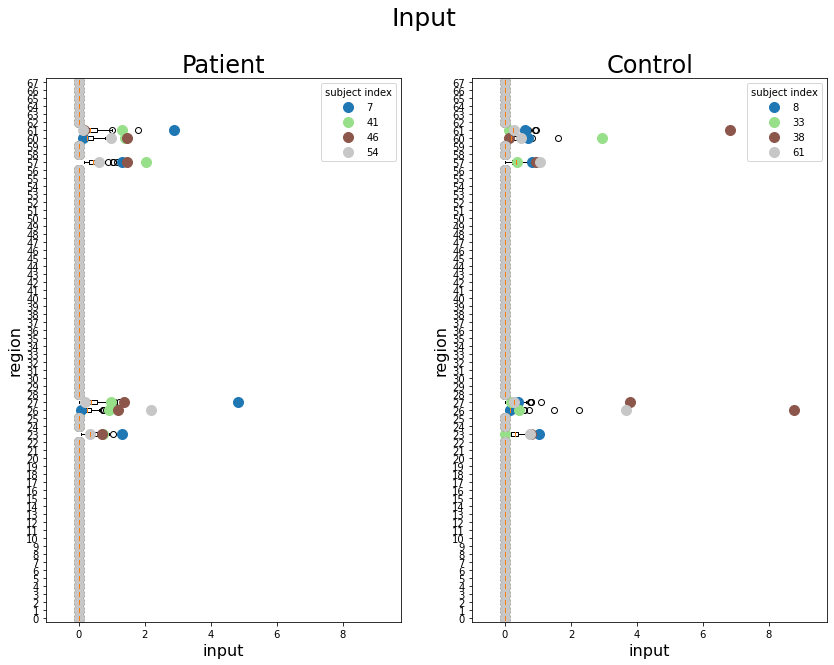

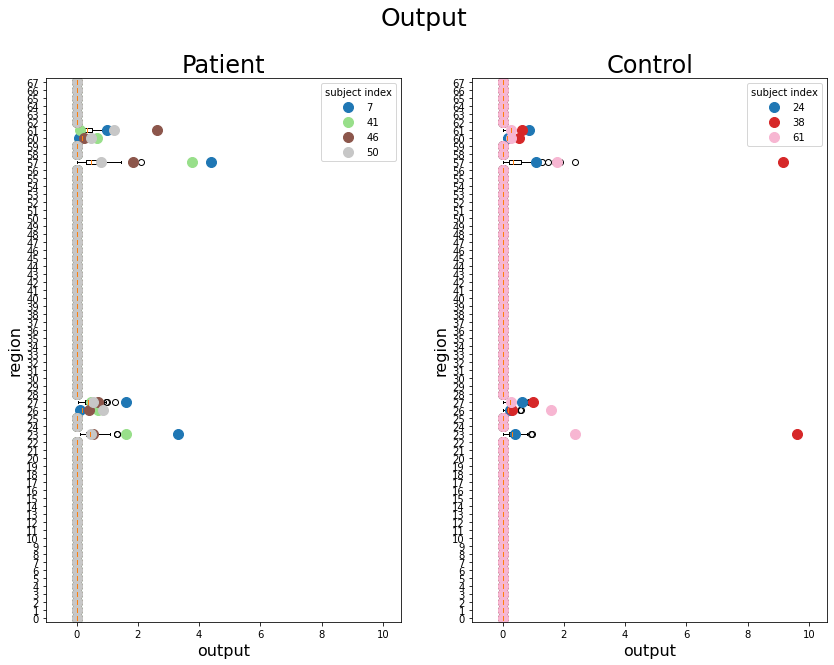

output_Counter_subjects_total_patients:
 Counter({7: 3, 50: 1, 41: 1, 46: 1})
output_Counter_subjects_total_controls:
 Counter({38: 4, 61: 1, 24: 1})
Mean rc input:	 0.0376220739640076 (patients)	 0.031233501604557967 (contols)


In [11]:
"""
Patients: Analyse input into rc with regard to max values. 
"""

n_max_values = 1
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_patients = Counter()
input_Counter_rois_total_patients = Counter()
output_Counter_subjects_total_patients = Counter()
output_Counter_rois_total_patients = Counter()
for i_max in range(n_max_values):
    max_values = np.outer(np.sort(input_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    max_values[max_values == 0] = -100
    condition = input_patients.T == max_values
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    input_Counter_subjects_total_patients += input_Counter_subjects

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
for i_max in range(n_max_values):
    max_values = np.outer(np.sort(output_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    max_values[max_values == 0] = -100
    condition = output_patients.T == max_values
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    output_Counter_subjects_total_patients += output_Counter_subjects
    
input_Counter_subjects_total_controls = Counter()
input_Counter_rois_total_controls = Counter()
output_Counter_subjects_total_controls = Counter()
output_Counter_rois_total_controls = Counter()
for i_max in range(n_max_values):
    max_values = np.outer(np.sort(input_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    max_values[max_values == 0] = -100
    condition = input_controls.T == max_values
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    input_Counter_subjects_total_controls += input_Counter_subjects

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
for i_max in range(n_max_values):
    max_values = np.outer(np.sort(output_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    max_values[max_values == 0] = -100
    condition = output_controls.T == max_values
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    output_Counter_subjects_total_controls += output_Counter_subjects

    
## Plot feeder input and output and color subjects who have the 1st, 2nd and 3rd maximal values.
suptitle_fontsize = 25
title_fontsize = 24
axis_lable_fontsize = 16
fontsize = 15
top_adjust = 0.88
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(red('Investigate input and output regionwise for RC-periphery'
          ' (feeder) connections:', 'bold'))

#plot_feeder_io_boxplot(input_patients, output_patients, 'Patients')
#plot_feeder_io_boxplot(input_controls, output_controls, 'Controls')
print(black('Patients:', 'bold'))
print('\ninput_Counter_subjects_total_patients:\n', input_Counter_subjects_total_patients)
print('\ninput_Counter_subjects_total_controls:\n', input_Counter_subjects_total_controls)
plot_input_output_boxplot(
    input_patients, output_patients, input_controls, output_controls, 'tab20')
print('output_Counter_subjects_total_patients:\n', output_Counter_subjects_total_patients)
print('output_Counter_subjects_total_controls:\n', output_Counter_subjects_total_controls)
print('Mean rc input:\t', input_patients.mean(),
  '(patients)\t', input_controls.mean(), '(contols)')

In [12]:
## Investigate per subject.
input_rc_patients = input_patients[:, indexes_rc]
input_rc_controls = input_controls[:, indexes_rc]
output_rc_patients = output_patients[:, indexes_rc]
output_rc_controls = output_controls[:, indexes_rc]
io_ratio_rc_patients = input_rc_patients/output_rc_patients
io_ratio_rc_controls = input_rc_controls/output_rc_controls

## 1st moment (mean).
print(black('1st moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_patients.mean(axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_controls.mean(axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_patients.mean())
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_controls.mean())
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_patients.mean(axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_controls.mean(axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_patients.mean())
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_controls.mean())
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_patients.mean(axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_controls.mean(axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_patients.mean())
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_controls.mean())

## 2nd moment (variance).
print(black('2nd moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_patients.var(axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', input_rc_controls.var(axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_patients.var())
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', input_rc_controls.var())
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_patients.var(axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', output_rc_controls.var(axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_patients.var())
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', output_rc_controls.var())
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_patients.var(axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', io_ratio_rc_controls.var(axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_patients.var())
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', io_ratio_rc_controls.var())

## 3rd moment (skewness).
print(black('3rd moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(input_rc_patients, axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(input_rc_controls, axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(input_rc_patients.reshape(-1)))
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(input_rc_controls.reshape(-1)))
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(output_rc_patients, axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(output_rc_controls, axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(output_rc_patients.reshape(-1)))
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(output_rc_controls.reshape(-1)))
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(io_ratio_rc_patients, axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.skew(io_ratio_rc_controls, axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(io_ratio_rc_patients.reshape(-1)))
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.skew(io_ratio_rc_controls.reshape(-1)))

## 4th moment (skewness).
print(black('4th moment:', 'bold'))
# Input:
print(black('\tPatients: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(input_rc_patients, axis=0))
print(black('\tControls: Input:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(input_rc_controls, axis=0))
print(black('\tPatients: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(input_rc_patients.reshape(-1)))
print(black('\tControls: Input:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(input_rc_controls.reshape(-1)))
# Output:
print(black('\tPatients: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(output_rc_patients, axis=0))
print(black('\tControls: Output:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(output_rc_controls, axis=0))
print(black('\tPatients: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(output_rc_patients.reshape(-1)))
print(black('\tControls: Output:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(output_rc_controls.reshape(-1)))
# io ratio:
print(black('\tPatients: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(io_ratio_rc_patients, axis=0))
print(black('\tControls: io ratio:', 'bold'), 'Feeder connections:\n\t\t', stt.kurtosis(io_ratio_rc_controls, axis=0))
print(black('\tPatients: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(io_ratio_rc_patients.reshape(-1)))
print(black('\tControls: io ratio:', 'bold'), 'Over all feeder connections and all subjects:\n\t\t', stt.kurtosis(io_ratio_rc_controls.reshape(-1)))

1st moment:
	Patients: Input: Feeder connections:
		 [0.42447614 0.32339639 0.48870072 0.50922473 0.33774502 0.47475803]
	Controls: Input: Feeder connections:
		 [0.32686275 0.41652245 0.34822088 0.34990827 0.30175999 0.38060377]
	Patients: Input: Over all feeder connections and all subjects:
		 0.42638350492541943
	Controls: Input: Over all feeder connections and all subjects:
		 0.35397968485165693
	Patients: Output: Feeder connections:
		 [0.5417082  0.24067828 0.43346161 0.69707765 0.19849721 0.44687808]
	Controls: Output: Feeder connections:
		 [0.51143531 0.22749544 0.29040792 0.63120254 0.16392304 0.29941385]
	Patients: Output: Over all feeder connections and all subjects:
		 0.4263835049254195
	Controls: Output: Over all feeder connections and all subjects:
		 0.353979684851657
	Patients: io ratio: Feeder connections:
		 [1.03138413        nan 1.17056053 5.13961992        nan 1.61181615]
	Controls: io ratio: Feeder connections:
		 [0.98622098        nan 1.17060645 0.8523265    

<ipython-input-12-daebf388fdf9>:6: RuntimeWarning: divide by zero encountered in true_divide
  io_ratio_rc_patients = input_rc_patients/output_rc_patients
<ipython-input-12-daebf388fdf9>:6: RuntimeWarning: invalid value encountered in true_divide
  io_ratio_rc_patients = input_rc_patients/output_rc_patients
<ipython-input-12-daebf388fdf9>:7: RuntimeWarning: divide by zero encountered in true_divide
  io_ratio_rc_controls = input_rc_controls/output_rc_controls
<ipython-input-12-daebf388fdf9>:7: RuntimeWarning: invalid value encountered in true_divide
  io_ratio_rc_controls = input_rc_controls/output_rc_controls
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


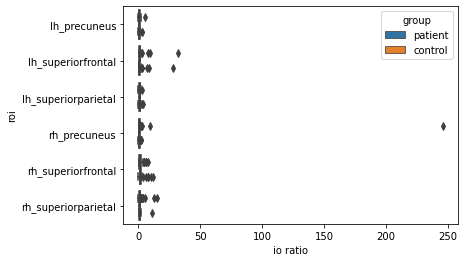

The patient`s variance in io ratio is greater than the control`s for 3 of 6 rc regions.


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [13]:
## Compare groups in one boxplot with respect to io ratio of rc regions. 
dataframe_patients = pd.DataFrame(io_ratio_rc_patients.reshape(-1),
                                  columns=['io ratio'])
dataframe_patients['group'] = np.repeat('patient', dataframe_patients.size)
dataframe_patients['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_patients, 1).reshape(-1)

dataframe_controls = pd.DataFrame(io_ratio_rc_controls.reshape(-1),
                                  columns=['io ratio'])
dataframe_controls['group'] = np.repeat('control', dataframe_controls.size)
dataframe_controls['roi'] = np.matlib.repmat(
    roi_labels[mask_rc], n_controls, 1).reshape(-1)

dataframe_all_subjects = dataframe_patients.append(dataframe_controls)

ax = sns.boxplot(x = dataframe_all_subjects['io ratio'], 
            y = dataframe_all_subjects['roi'], 
            hue = dataframe_all_subjects['group'])
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":16})
#ax.set_title("Title",fontsize=24)
plt.show()
roi_count_patients_greater_than_controls = sum(
    np.var(io_ratio_rc_patients, axis=0) > np.var(io_ratio_rc_controls, axis=0))
print('The patient`s variance in io ratio is greater than the control`s for', 
      roi_count_patients_greater_than_controls, 'of', 
      len(indexes_rc), 'rc regions.')

In [14]:
"""
Patients: Analyse input into rc with regard to max values. 
"""

n_max_values = 5
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_patients = Counter()
input_Counter_rois_total_patients = Counter()
output_Counter_subjects_total_patients = Counter()
output_Counter_rois_total_patients = Counter()
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_patients.T == np.outer(np.sort(
        input_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_subjects)
    print(sorted(input_Counter_subjects))
    input_Counter_subjects_total_patients += input_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Input: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_patients == np.outer(np.sort(
        input_patients, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    input_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_rois)
    print(sorted(input_Counter_rois))
    input_Counter_rois_total_patients += input_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
print(black('Output: Examine the subjects responsible for the largest value per region:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_patients.T == np.outer(np.sort(
        output_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_subjects)
    print(sorted(output_Counter_subjects))
    output_Counter_subjects_total_patients += output_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Output: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_patients == np.outer(np.sort(
        output_patients, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    output_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_rois)
    print(sorted(output_Counter_rois))
    output_Counter_rois_total_patients += output_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc io ratio with regard to max values. 
print(black('Examine the subjects responsible for the largest io ratio:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = io_ratio_rc_patients.T == np.outer(np.sort(
        io_ratio_rc_patients, axis=0)[-i_max-1, :], np.ones([n_patients]))
    print(np.asarray(condition).nonzero())
    print(Counter(np.asarray(condition).nonzero()[1]))
    print(sorted(Counter(np.asarray(condition).nonzero()[1])))
    

Input: Examine the subjects responsible for the largest value per region:
	 1. largest value
(array([ 0,  0,  0, ..., 67, 67, 67], dtype=int64), array([ 0,  1,  2, ..., 57, 58, 59], dtype=int64))
Counter({7: 65, 41: 63, 46: 63, 54: 63, 0: 62, 1: 62, 2: 62, 3: 62, 4: 62, 5: 62, 6: 62, 8: 62, 9: 62, 10: 62, 11: 62, 12: 62, 13: 62, 14: 62, 15: 62, 16: 62, 17: 62, 18: 62, 19: 62, 20: 62, 21: 62, 22: 62, 23: 62, 24: 62, 25: 62, 26: 62, 27: 62, 28: 62, 29: 62, 30: 62, 31: 62, 32: 62, 33: 62, 34: 62, 35: 62, 36: 62, 37: 62, 38: 62, 39: 62, 40: 62, 42: 62, 43: 62, 44: 62, 45: 62, 47: 62, 48: 62, 49: 62, 50: 62, 51: 62, 52: 62, 53: 62, 55: 62, 56: 62, 57: 62, 58: 62, 59: 62})
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
	 2. largest value
(array([ 0,  0,  0, ..., 67, 67, 67], dtype=int64), array([ 0,  1,  2, ...

In [15]:
"""
Patients: Analyse input from the periphery into the rc with regard
to max values. 
"""

n_max_values = 5
# Find subjects responsible for the outliers.
print(black('Input: Examine the subjects responsible for the largest value per region:', 'bold'))
input_Counter_subjects_total_controls = Counter()
input_Counter_rois_total_controls = Counter()
output_Counter_subjects_total_controls = Counter()
output_Counter_rois_total_controls = Counter()
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_controls.T == np.outer(np.sort(
        input_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    input_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_subjects)
    print(sorted(input_Counter_subjects))
    input_Counter_subjects_total_controls += input_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Input: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = input_controls == np.outer(np.sort(
        input_controls, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    input_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(input_Counter_rois)
    print(sorted(input_Counter_rois))
    input_Counter_rois_total_controls += input_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc output with regard to max values.
# Find subjects responsible for the outliers.
print(black('Output: Examine the subjects responsible for the largest value per region:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_controls.T == np.outer(np.sort(
        output_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    output_Counter_subjects = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_subjects)
    print(sorted(output_Counter_subjects))
    output_Counter_subjects_total_controls += output_Counter_subjects
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))
# Find rois responsible for the largest values per subject
print(black('RC-indexes:\n', 'bold'), indexes_rc)
print(black('Output: Examine the rois responsible for the largest value per subject:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = output_controls == np.outer(np.sort(
        output_controls, axis=1)[:, -i_max-1], np.ones([n_rois]))
    print(np.asarray(condition).nonzero())
    output_Counter_rois = Counter(np.asarray(condition).nonzero()[1])
    print(output_Counter_rois)
    print(sorted(output_Counter_rois))
    output_Counter_rois_total_controls += output_Counter_rois
    #print(sorted(list(unique_everseen(np.asarray(condition).nonzero()[1]))))

## Analyse rc io ratio with regard to max values. 
print(black('Examine the subjects responsible for the largest io ratio:', 'bold'))
for i_max in range(n_max_values):
    print('\t', str(i_max+1) + '. largest value')
    condition = io_ratio_rc_controls.T == np.outer(np.sort(
        io_ratio_rc_controls, axis=0)[-i_max-1, :], np.ones([n_controls]))
    print(np.asarray(condition).nonzero())
    print(Counter(np.asarray(condition).nonzero()[1]))
    print(sorted(Counter(np.asarray(condition).nonzero()[1])))

Input: Examine the subjects responsible for the largest value per region:
	 1. largest value
(array([ 0,  0,  0, ..., 67, 67, 67], dtype=int64), array([ 0,  1,  2, ..., 66, 67, 68], dtype=int64))
Counter({38: 65, 8: 63, 33: 63, 61: 63, 0: 62, 1: 62, 2: 62, 3: 62, 4: 62, 5: 62, 6: 62, 7: 62, 9: 62, 10: 62, 11: 62, 12: 62, 13: 62, 14: 62, 15: 62, 16: 62, 17: 62, 18: 62, 19: 62, 20: 62, 21: 62, 22: 62, 23: 62, 24: 62, 25: 62, 26: 62, 27: 62, 28: 62, 29: 62, 30: 62, 31: 62, 32: 62, 34: 62, 35: 62, 36: 62, 37: 62, 39: 62, 40: 62, 41: 62, 42: 62, 43: 62, 44: 62, 45: 62, 46: 62, 47: 62, 48: 62, 49: 62, 50: 62, 51: 62, 52: 62, 53: 62, 54: 62, 55: 62, 56: 62, 57: 62, 58: 62, 59: 62, 60: 62, 62: 62, 63: 62, 64: 62, 65: 62, 66: 62, 67: 62, 68: 62})
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6

In [16]:
## Compare patients and controls with respect to the maximum io values (feeder).
print(indexes_rc)
print(black('Patients:', 'bold'))
print('\ninput_Counter_subjects_total_patients:', input_Counter_subjects_total_patients)
print('output_Counter_subjects_total_patients:', output_Counter_subjects_total_patients)
print('\ninput_Counter_rois_total_patients:', input_Counter_rois_total_patients)
print('output_Counter_rois_total_patients:', output_Counter_rois_total_patients)
print(black('Controls:', 'bold'))
print('\ninput_Counter_subjects_total_controls:', input_Counter_subjects_total_controls)
print('output_Counter_subjects_total_controls:', output_Counter_subjects_total_controls)
print('\ninput_Counter_rois_total_controls:', input_Counter_rois_total_controls)
print('output_Counter_rois_total_controls:', output_Counter_rois_total_controls)

[23 26 27 57 60 61]
Patients:

input_Counter_subjects_total_patients: Counter({7: 314, 41: 314, 46: 314, 5: 313, 58: 313, 12: 312, 54: 312, 0: 311, 8: 311, 9: 311, 31: 311, 35: 311, 37: 311, 50: 311, 55: 311, 1: 310, 2: 310, 3: 310, 4: 310, 6: 310, 10: 310, 11: 310, 13: 310, 14: 310, 15: 310, 16: 310, 17: 310, 18: 310, 19: 310, 20: 310, 21: 310, 22: 310, 23: 310, 24: 310, 25: 310, 26: 310, 27: 310, 28: 310, 29: 310, 30: 310, 32: 310, 33: 310, 34: 310, 36: 310, 38: 310, 39: 310, 40: 310, 42: 310, 43: 310, 44: 310, 45: 310, 47: 310, 48: 310, 49: 310, 51: 310, 52: 310, 53: 310, 56: 310, 57: 310, 59: 310})
output_Counter_subjects_total_patients: Counter({41: 314, 58: 314, 5: 313, 7: 313, 50: 313, 12: 312, 46: 312, 54: 312, 3: 311, 11: 311, 17: 311, 20: 311, 35: 311, 51: 311, 55: 311, 0: 310, 1: 310, 2: 310, 4: 310, 6: 310, 8: 310, 9: 310, 10: 310, 13: 310, 14: 310, 15: 310, 16: 310, 18: 310, 19: 310, 21: 310, 22: 310, 23: 310, 24: 310, 25: 310, 26: 310, 27: 310, 28: 310, 29: 310, 30: 310, 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1786: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s



Patient group:
4 of 6 rc regions significantly (5%) differ from a normal distribution.


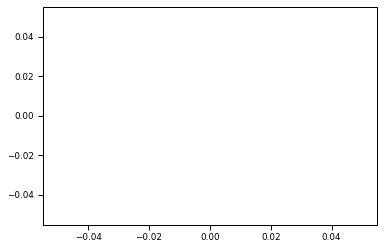

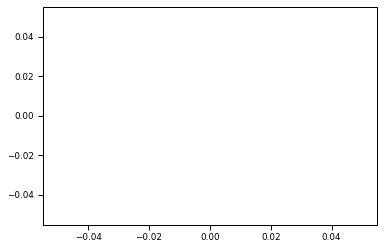

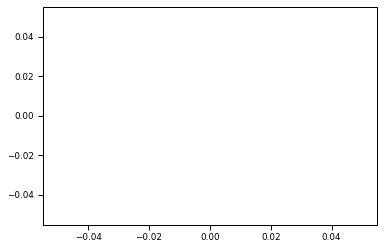

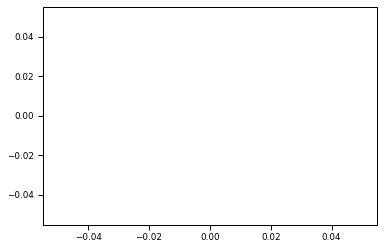

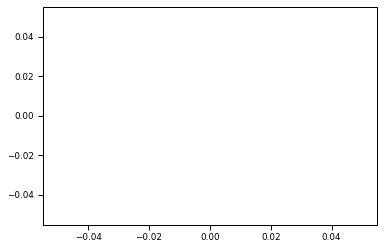

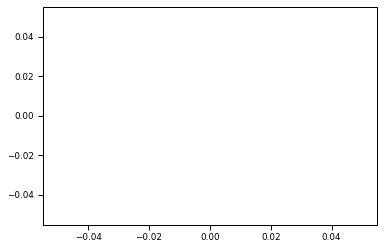


Control group:
3 of 6 rc regions significantly (5%) differ from a normal distribution.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1786: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s


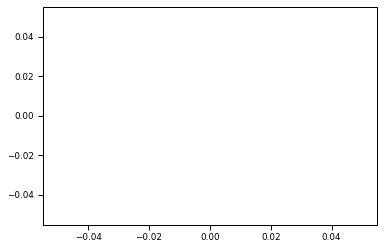

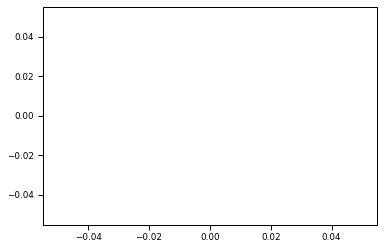

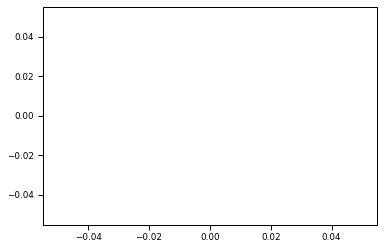

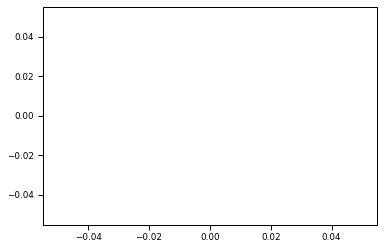

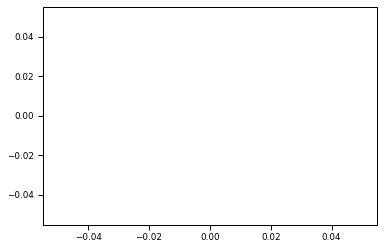

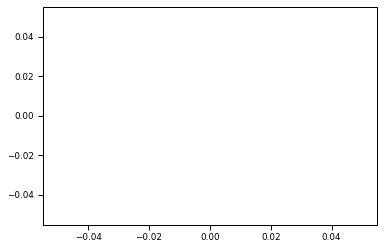

In [17]:
## Test feeder io ratio for normal distribution
def test_for_normal_dist(array_2D):
    n_subjects = np.fmin(n_patients, n_controls)
    array_2D = array_2D[:n_subjects]
    significance_level_ind = 2
    significance_level = stt.anderson(
        np.ones(2)).significance_level[significance_level_ind]
    anderson_results = np.array([stt.anderson(dist).statistic
                        > stt.anderson(dist).critical_values[2]
                                 for dist in array_2D.T], dtype=bool)
    print(np.array(np.where(anderson_results)).shape[1], 'of', 
          array_2D.shape[1], str('rc regions significantly ('
                                 + str(int(significance_level)) + '%)'), 
          'differ from a normal distribution.')
    [(plt.figure(), plt.hist(dist, bins=np.linspace(
        array_2D.min(), array_2D.max(), 100))) for dist in array_2D.T ]
    plt.show()
## Test each subject's data as a whole on normal distribution
#anderson2 = np.array([(stt.anderson(x).statistic > stt.anderson(x).critical_values[2]) for x in ts_patients.reshape(n_patients, -1)], dtype=bool)
#print(anderson2.shape)
#np.array(np.where(anderson2)).shape
print(black('\nPatient group:', 'bold'))
test_for_normal_dist(io_ratio_rc_patients)
print(black('\nControl group:', 'bold'))
test_for_normal_dist(io_ratio_rc_controls)


Patient group:
6 of 6 rc regions significantly (5%) differ from a normal distribution.


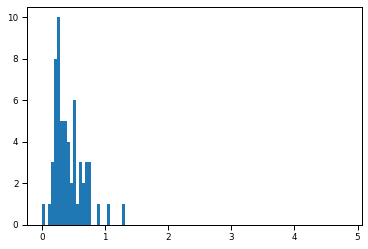

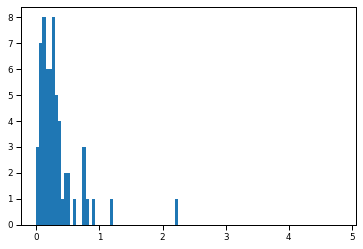

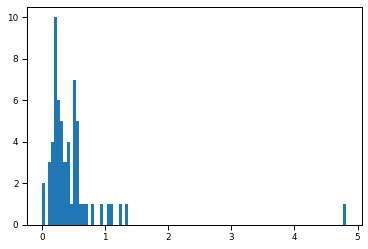

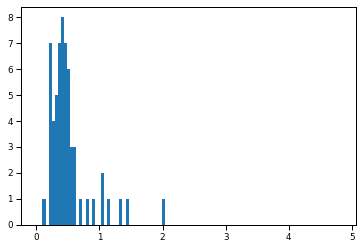

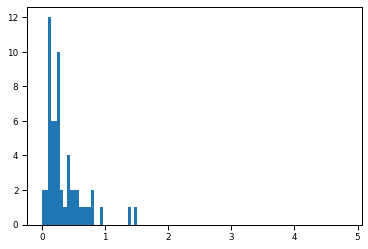

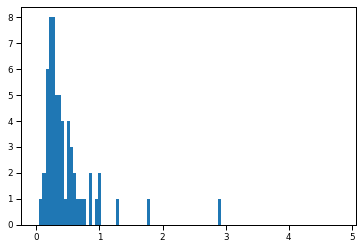


Control group:
6 of 6 rc regions significantly (5%) differ from a normal distribution.


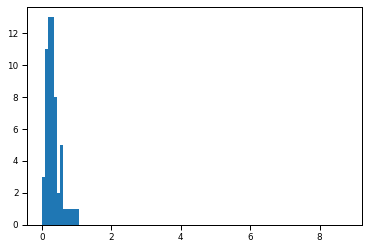

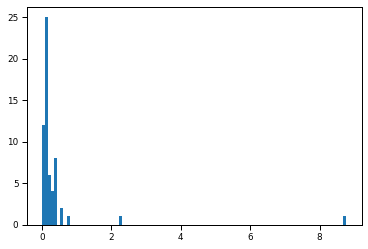

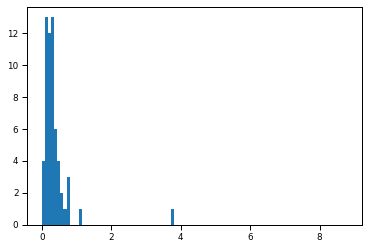

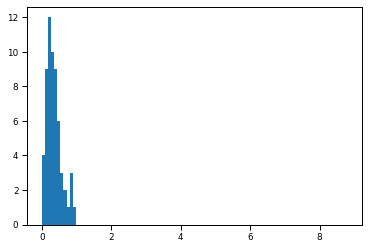

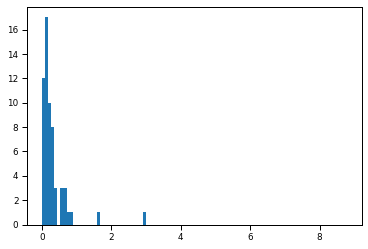

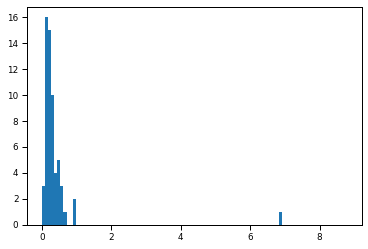

In [18]:
## Test inputs for normal distribution.
input_rc_patients = input_patients[:, mask_rc]
input_rc_controls = input_controls[:, mask_rc]
print(black('\nPatient group:', 'bold'))
test_for_normal_dist(input_rc_patients)
print(black('\nControl group:', 'bold'))
test_for_normal_dist(input_rc_controls)

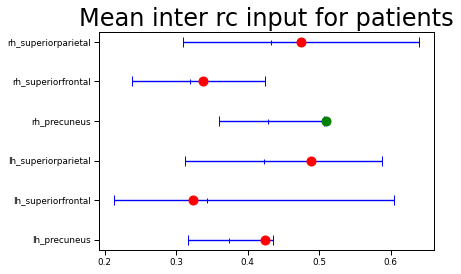

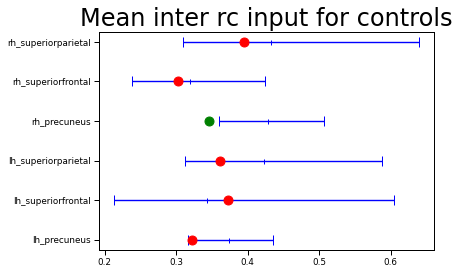

In [19]:
## Examine significance of mean of rc input (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean inter rc input'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_rc_patients[:n_subjects],
                              input_rc_controls[:n_subjects],
                              input_rc_patients[:n_subjects].mean(axis=0),
                              input_rc_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)
else:
    examine_significance(input_rc_patients, input_rc_controls,
                              input_rc_patients.mean(axis=0),
                              input_rc_controls.mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)

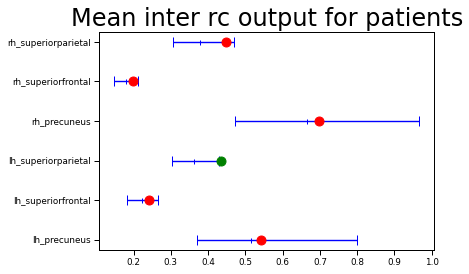

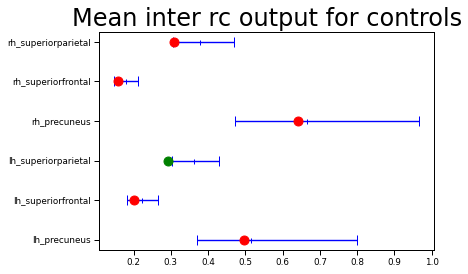

In [20]:
## Examine significance of mean of rc output (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean inter rc output'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(output_rc_patients[:n_subjects],
                              output_rc_controls[:n_subjects],
                              output_rc_patients[:n_subjects].mean(axis=0),
                              output_rc_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)
else:
    examine_significance(output_rc_patients, output_rc_controls,
                              output_rc_patients.mean(axis=0),
                              output_rc_controls.mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)

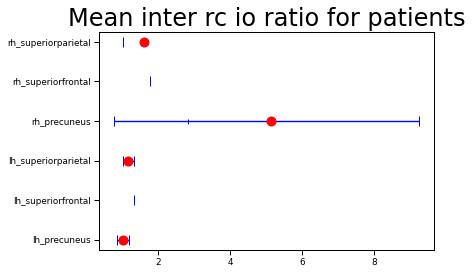

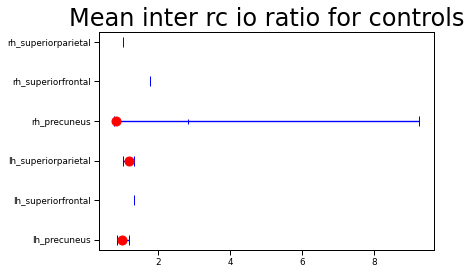

In [21]:
## Examine significance of mean of io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Mean inter rc io ratio'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_rc_patients,
                              io_ratio_rc_controls,
                              io_ratio_rc_patients[:n_subjects].mean(axis=0),
                              io_ratio_rc_controls[:n_subjects].mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)
else:
    examine_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                              io_ratio_rc_patients.mean(axis=0),
                              io_ratio_rc_controls.mean(axis=0),
                              statistic_description, y_labels, alpha, np.mean)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


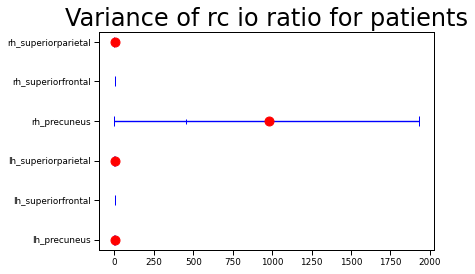

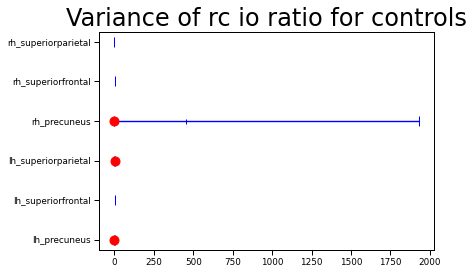

In [22]:
## Examine significance of variance of rc io ratio (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Variance of rc io ratio'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                         np.var(io_ratio_rc_patients[:n_subjects], axis=0),
                         np.var(io_ratio_rc_controls[:n_subjects], axis=0),
                         statistic_description, y_labels, alpha, np.var)
else:
    examine_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                         np.var(io_ratio_rc_patients, axis=0),
                         np.var(io_ratio_rc_controls, axis=0),
                         statistic_description, y_labels, alpha, np.var)

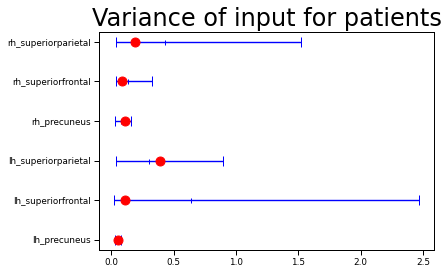

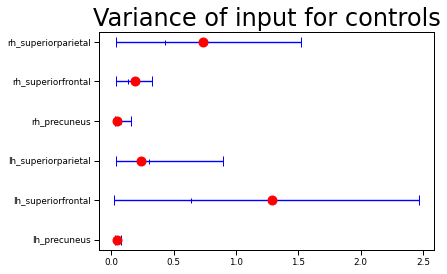

In [23]:
## Examine significance of variance of rc input (feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Variance of input'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_patients[:, mask_rc],
                             input_controls[:, mask_rc],
                             np.var(input_patients[:n_subjects, mask_rc], axis=0),
                             np.var(input_controls[:n_subjects, mask_rc], axis=0),
                             statistic_description, y_labels, alpha, np.var)
else:
    examine_significance(input_patients[:, mask_rc],
                             input_controls[:, mask_rc],
                             np.var(input_patients, axis=0),
                             np.var(input_controls, axis=0),
                             statistic_description, y_labels, alpha, np.var)

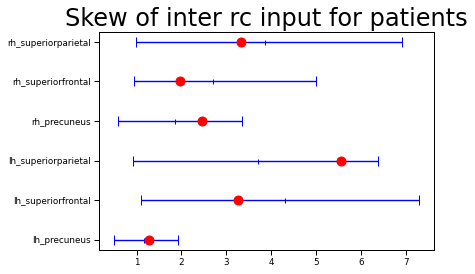

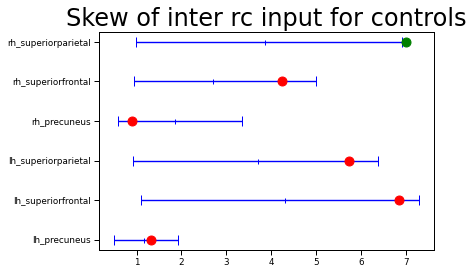

In [24]:
## Examine significance of skew of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Skew of inter rc input'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_rc_patients,
                              input_rc_controls,
                              stt.skew(input_rc_patients[:n_subjects], axis=0),
                              stt.skew(input_rc_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, alpha, stt.skew)
else:
    examine_significance(input_rc_patients, input_rc_controls,
                              stt.skew(input_rc_patients, axis=0),
                              stt.skew(input_rc_controls, axis=0),
                              statistic_description, y_labels, alpha, stt.skew)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1082: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


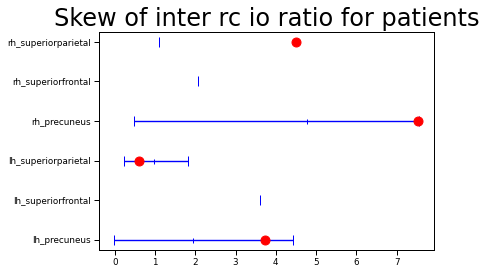

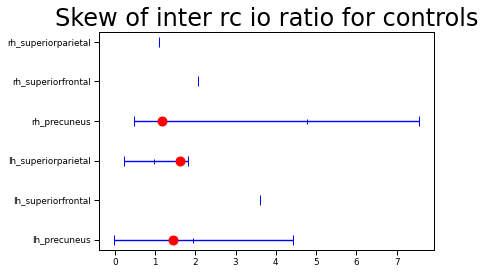

In [25]:
## Examine significance of skew of input(feeder)
alpha = 0.95
sample_groupsize = 'matched'
#sample_groupsize = 'all subjects'
statistic_description = 'Skew of inter rc io ratio'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(io_ratio_rc_patients,
                              io_ratio_rc_controls,
                              stt.skew(io_ratio_rc_patients[:n_subjects], axis=0),
                              stt.skew(io_ratio_rc_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, alpha, stt.skew)
else:
    examine_significance(io_ratio_rc_patients, io_ratio_rc_controls,
                              stt.skew(io_ratio_rc_patients, axis=0),
                              stt.skew(io_ratio_rc_controls, axis=0),
                              statistic_description, y_labels, alpha, stt.skew)

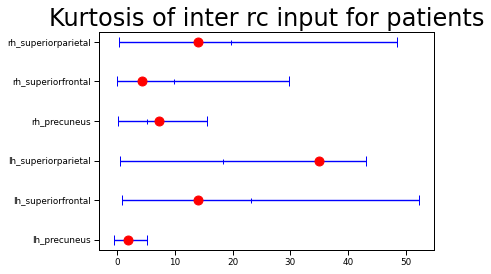

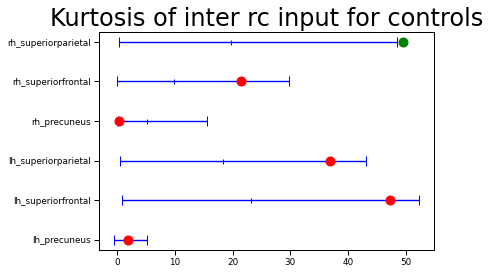

In [26]:
## Examine significance of kurtosis of input(feeder)
#sample_groupsize = 'matched'#'all subjects'
alpha = 0.95
statistic_description = 'Kurtosis of inter rc input'
y_labels = roi_labels[indexes_rc]
if sample_groupsize== 'matched':
    n_subjects = np.fmin(n_patients, n_controls)
    examine_significance(input_rc_patients,
                              input_rc_controls,
                              stt.kurtosis(input_rc_patients[:n_subjects], axis=0),
                              stt.kurtosis(input_rc_controls[:n_subjects], axis=0),
                              statistic_description, y_labels, alpha, stt.kurtosis)
else:
    examine_significance(input_rc_patients, input_rc_controls,
                              stt.kurtosis(input_rc_patients, axis=0),
                              stt.kurtosis(input_rc_controls, axis=0),
                              statistic_description, y_labels, alpha, stt.kurtosis)

In [31]:
## Cluster-based bootstrapping according to section 2.5
perform_rc_bootstrapping_flag=False
n_samples = 10000

if perform_rc_bootstrapping_flag:
    # Create a 2D-mask for inter rich club connections.
    mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
    rc_ind_combin = np.array(list(
        itertools.product(indexes_rc, repeat=2))).T
    mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True
    # Create a 2D-mask for inter periphery connections.
    mask_inter_periph = np.zeros([n_rois, n_rois], dtype=bool)
    periph_ind_combin = np.array(list(itertools.product(list(
        x for x in range(n_rois) if x not in indexes_rc), repeat=2))).T
    mask_inter_periph[periph_ind_combin[0], periph_ind_combin[1]] = True
    
    ## Examine the patients group.
    n_subjects = min(n_patients, n_controls)
    inter_rc_input_patients = np.zeros([n_subjects])
    inter_periph_input_patients = np.zeros([n_subjects])
    inter_sampled_rc_input_patients = np.zeros([n_subjects, n_samples])
    inter_sampled_periph_input_patients = np.zeros([n_subjects, n_samples])

    np.random.seed(seed)
    for i_patient in range(n_subjects):
        print('patient', i_patient)
        inter_rc_input, _ = calculate_inter_rc_input_and_output(
            EC_patients[i_patient, :, :], mask_inter_rc)
        inter_rc_input_patients[i_patient] = inter_rc_input.sum()

        inter_periph_input, _ = calculate_inter_periph_input_and_output(
            EC_patients[i_patient, :, :], mask_inter_periph)
        inter_periph_input_patients[i_patient] = inter_periph_input.sum()

        for i_sample in range(n_samples):
            ## Calculate the inter-sampled-rc input.
            i_index_sample = np.random.choice(
                np.arange(n_rois), size=len(indexes_rc))
            # Create a 1D-mask for sampled rc rois.
            mask_i_sampled_rc = np.zeros(n_rois, dtype=bool)
            mask_i_sampled_rc[i_index_sample] = True
            # Create a 2D-mask for sampled inter-rc connections.
            mask_inter_sampled_rc = np.zeros([n_rois, n_rois], dtype=bool)
            sample_index_combin = np.array(list(
                itertools.product(i_index_sample, repeat=2))).T
            mask_inter_sampled_rc[sample_index_combin[0],
                                  sample_index_combin[1]] = True

            inter_rc_input, _ = calculate_inter_rc_input_and_output(
            EC_patients[i_patient, :, :], mask_inter_sampled_rc)
            inter_sampled_rc_input_patients[i_patient, i_sample] = \
            inter_rc_input.sum()

            ## Calculate the inter-sampled-periph input.
            # Create a 1D-mask for sampled periph rois.
            mask_i_sampled_periph = np.zeros(n_rois, dtype=bool)
            mask_i_sampled_periph[~i_index_sample] = True
            # Create a 2D-mask for sampled inter-periph connections.
            mask_inter_sampled_periph = np.zeros([n_rois, n_rois], dtype=bool)
            sample_index_combin = np.array(list(
                itertools.product(~i_index_sample, repeat=2))).T
            mask_inter_sampled_periph[sample_index_combin[0],
                                      sample_index_combin[1]] = True

            inter_periph_input, _ = calculate_inter_periph_input_and_output(
            EC_patients[i_patient, :, :], mask_i_sampled_periph)
            inter_sampled_periph_input_patients[i_patient, i_sample] = \
            inter_periph_input.sum()

    ## Examine the control group.
    inter_rc_input_controls = np.zeros([n_subjects])
    inter_periph_input_controls = np.zeros([n_subjects])
    inter_sampled_rc_input_controls = np.zeros([n_subjects, n_samples])
    inter_sampled_periph_input_controls = np.zeros([n_subjects, n_samples])

    np.random.seed(seed)
    for i_control in range(n_subjects):
        print('control', i_control)
        inter_rc_input, _ = calculate_inter_rc_input_and_output(
            EC_controls[i_control, :, :], mask_inter_rc)
        inter_rc_input_controls[i_control] = inter_rc_input.sum()

        inter_periph_input, _ = calculate_inter_periph_input_and_output(
            EC_controls[i_control, :, :], mask_inter_periph)
        inter_periph_input_controls[i_control] = inter_periph_input.sum()

        for i_sample in range(n_samples):
            ## Calculate the inter-sampled-rc input.
            i_index_sample = np.random.choice(
                np.arange(n_rois), size=len(indexes_rc))
            # Create a 1D-mask for sampled rc rois.
            mask_i_sampled_rc = np.zeros(n_rois, dtype=bool)
            mask_i_sampled_rc[i_index_sample] = True
            # Create a 2D-mask for sampled inter-rc connections.
            mask_inter_sampled_rc = np.zeros([n_rois, n_rois], dtype=bool)
            sample_index_combin = np.array(list(
                itertools.product(i_index_sample, repeat=2))).T
            mask_inter_sampled_rc[sample_index_combin[0],
                                  sample_index_combin[1]] = True

            inter_rc_input, _ = calculate_inter_rc_input_and_output(
            EC_controls[i_control, :, :], mask_inter_sampled_rc)
            inter_sampled_rc_input_controls[i_control, i_sample] = \
            inter_rc_input.sum()

            ## Calculate the inter-sampled-periph input.
            # Create a 1D-mask for sampled periph rois.
            mask_i_sampled_periph = np.zeros(n_rois, dtype=bool)
            mask_i_sampled_periph[~i_index_sample] = True
            # Create a 2D-mask for sampled inter-periph connections.
            mask_inter_sampled_periph = np.zeros([n_rois, n_rois], dtype=bool)
            sample_index_combin = np.array(list(
                itertools.product(~i_index_sample, repeat=2))).T
            mask_inter_sampled_periph[sample_index_combin[0],
                                      sample_index_combin[1]] = True

            inter_periph_input, _ = calculate_inter_periph_input_and_output(
            EC_controls[i_control, :, :], mask_i_sampled_periph)
            inter_sampled_periph_input_controls[i_control, i_sample] = \
            inter_periph_input.sum()
    patients_dict = dict(inter_rc_input_patients =
                         inter_rc_input_patients,
                         inter_periph_input_patients =
                         inter_periph_input_patients,
                         inter_sampled_rc_input_patients =
                         inter_sampled_rc_input_patients,
                         inter_sampled_periph_input_patients =
                         inter_sampled_periph_input_patients)
    controls_dict = dict(inter_rc_input_controls =
                         inter_rc_input_controls,
                         inter_periph_input_controls =
                         inter_periph_input_controls,
                         inter_sampled_rc_input_controls =
                         inter_sampled_rc_input_controls,
                         inter_sampled_periph_input_controls =
                         inter_sampled_periph_input_controls)
    rc_bootstrapping_dict = dict(patients_dict=patients_dict,
                                 controls_dict=controls_dict)
    #np.save(_RES_DIR + 'rc_bootstrapping' + str(n_samples)
    #        + '_samples' + '_seed_' + str(seed) + '.npy',
    #        rc_bootstrapping_dict, allow_pickle=True)
else:
    rc_bootstrapping_dict = np.load(_RES_DIR + 'rc_bootstrapping'
                                    + str(n_samples) + '_samples' + '_seed_'
                                    + str(seed) + '.npy',
                                    allow_pickle=True).tolist()
    inter_sampled_rc_input_controls = rc_bootstrapping_dict[
        'controls_dict']['inter_sampled_rc_input_controls']
    inter_rc_input_controls = rc_bootstrapping_dict[
        'controls_dict']['inter_rc_input_controls']
    inter_sampled_rc_input_patients = rc_bootstrapping_dict[
        'patients_dict']['inter_sampled_rc_input_patients']
    inter_rc_input_patients = rc_bootstrapping_dict[
        'patients_dict']['inter_rc_input_patients']

patient 0
patient 1
patient 2
patient 3
patient 4
patient 5
patient 6
patient 7
patient 8
patient 9
patient 10
patient 11
patient 12
patient 13
patient 14
patient 15
patient 16
patient 17
patient 18
patient 19
patient 20
patient 21
patient 22
patient 23
patient 24
patient 25
patient 26
patient 27
patient 28
patient 29
patient 30
patient 31
patient 32
patient 33
patient 34
patient 35
patient 36
patient 37
patient 38
patient 39
patient 40
patient 41
patient 42
patient 43
patient 44
patient 45
patient 46
patient 47
patient 48
patient 49
patient 50
patient 51
patient 52
patient 53
patient 54
patient 55
patient 56
patient 57
patient 58
patient 59
control 0
control 1
control 2
control 3
control 4
control 5
control 6
control 7
control 8
control 9
control 10
control 11
control 12
control 13
control 14
control 15
control 16
control 17
control 18
control 19
control 20
control 21
control 22
control 23
control 24
control 25
control 26
control 27
control 28
control 29
control 30
control 31
control 

Determine significance of choice of RC regions with respect to the inter-rc input:
The calculations are based on FC_scaled  with standard_scale .


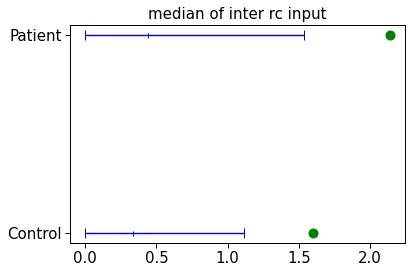

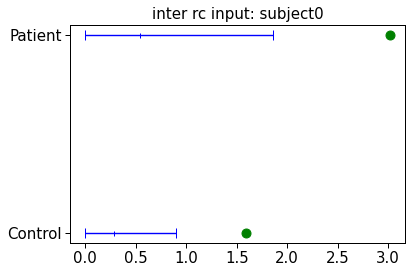

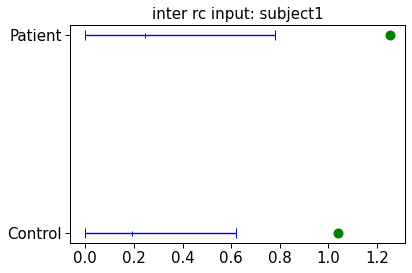

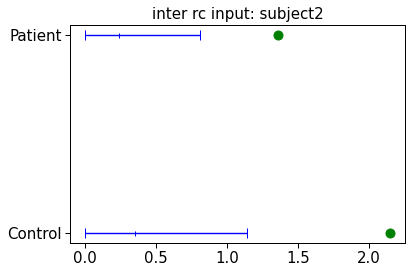

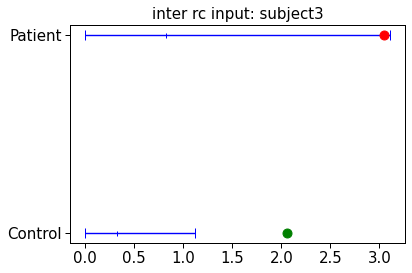

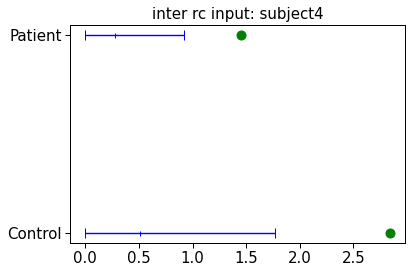

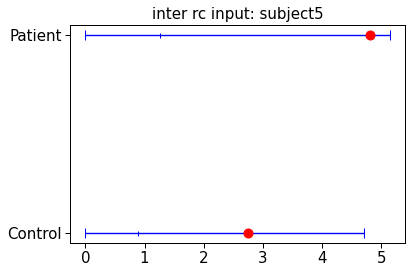

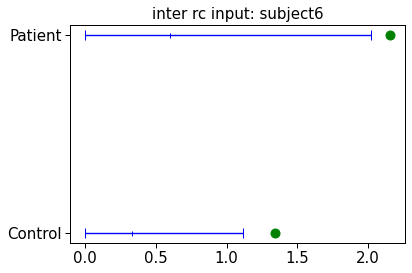

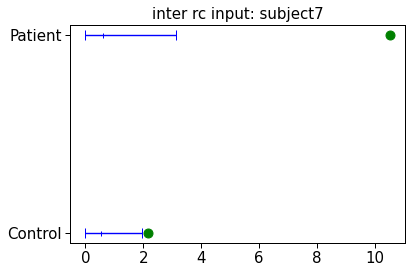

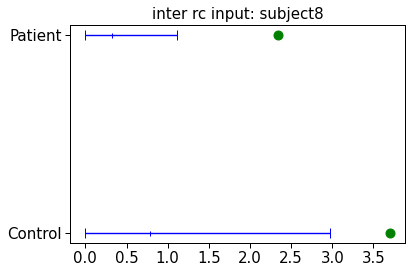

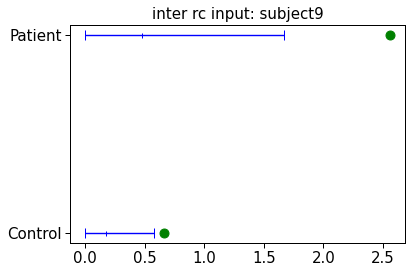

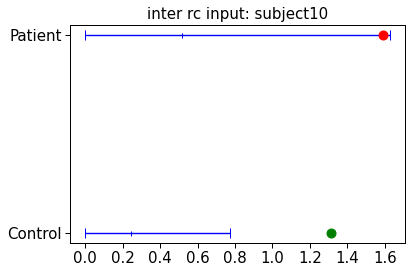

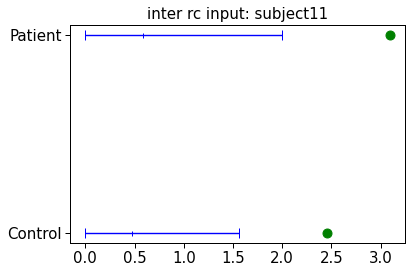

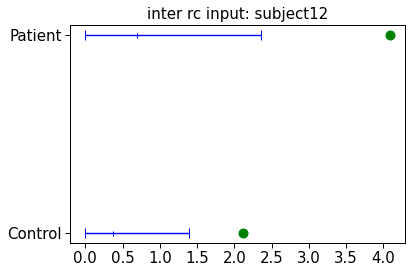

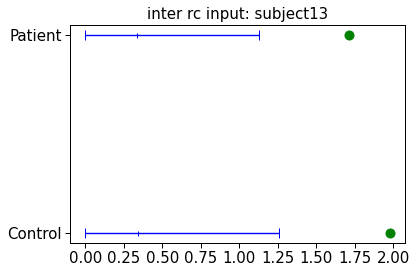

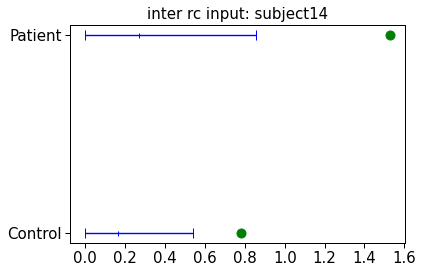

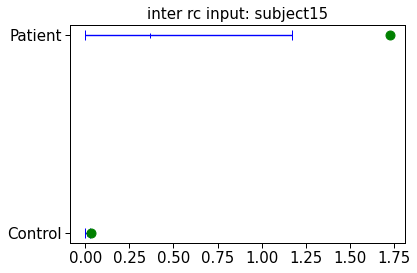

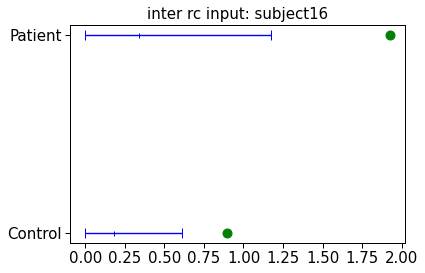

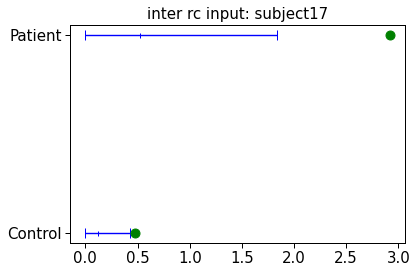

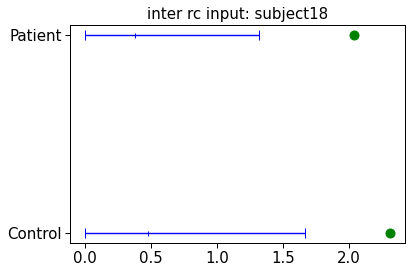

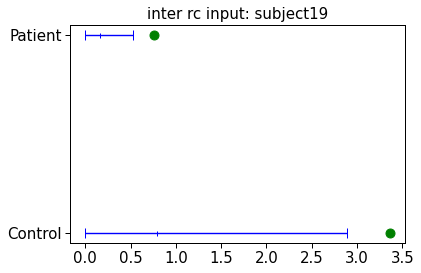

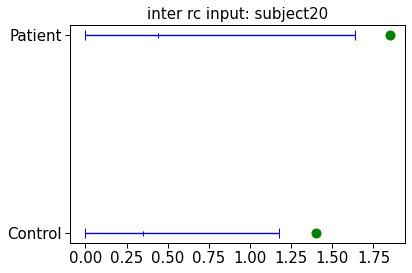

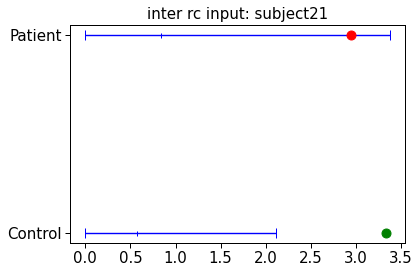

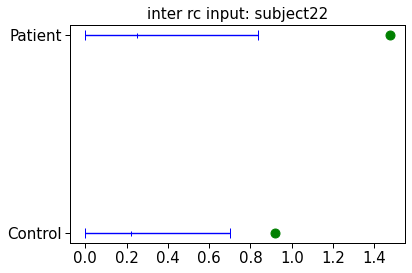

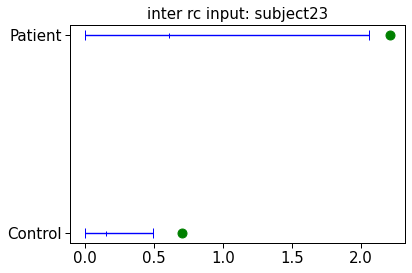

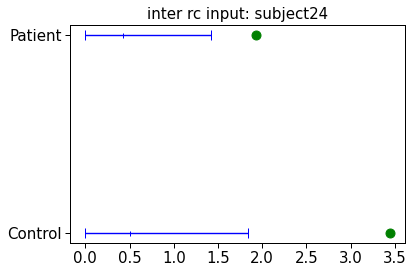

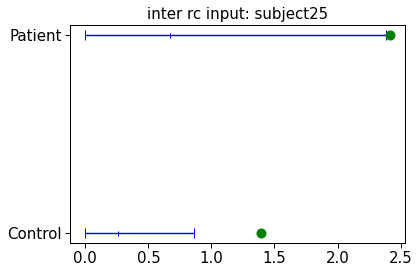

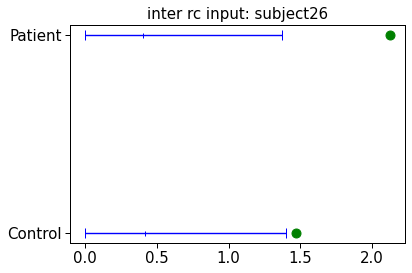

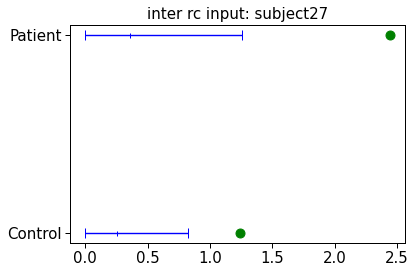

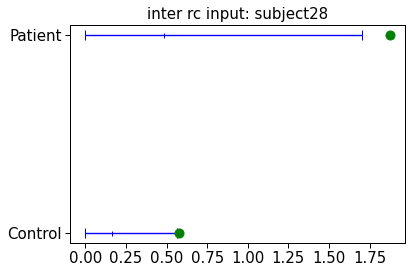

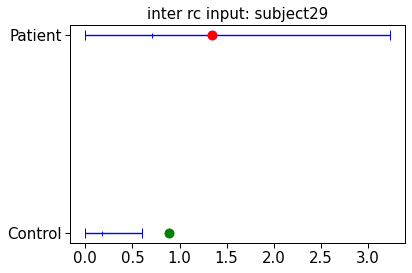

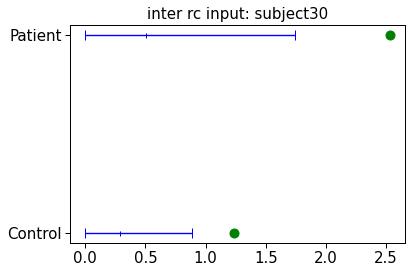

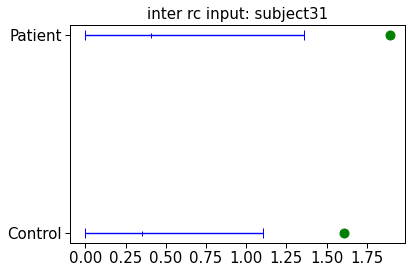

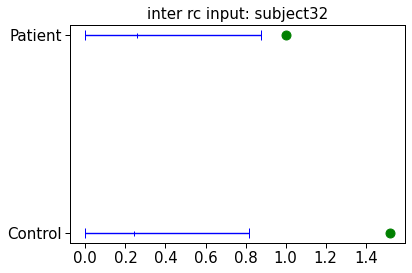

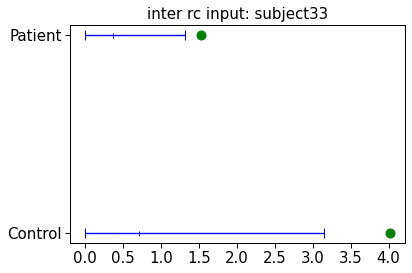

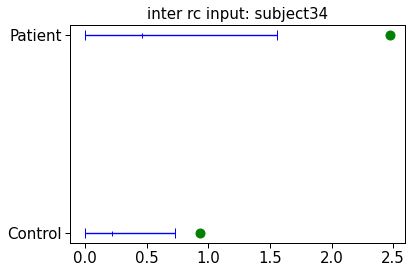

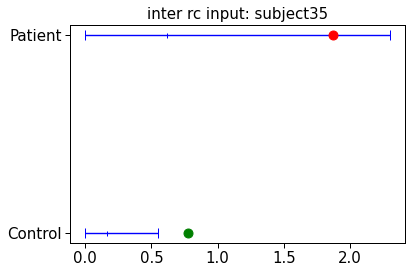

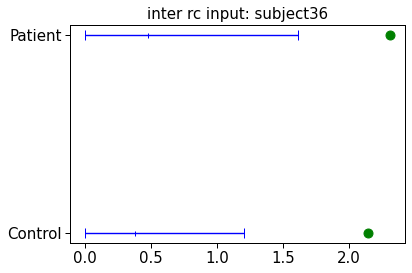

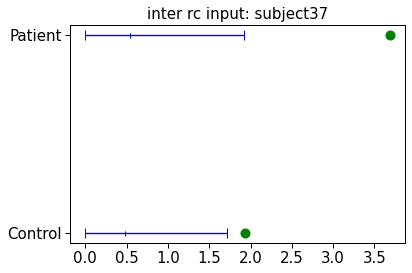

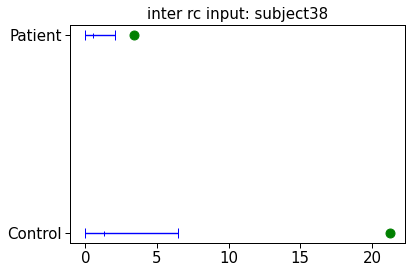

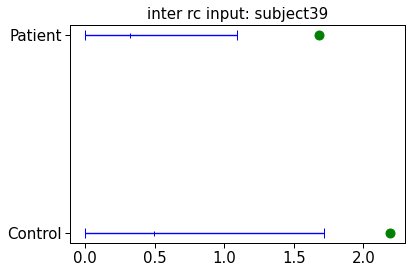

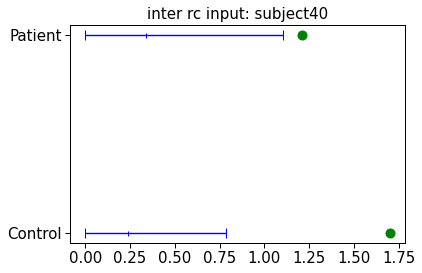

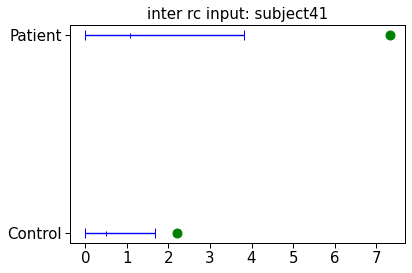

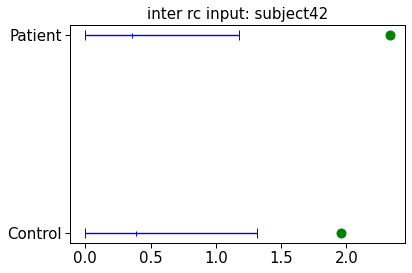

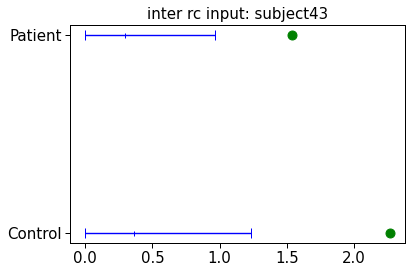

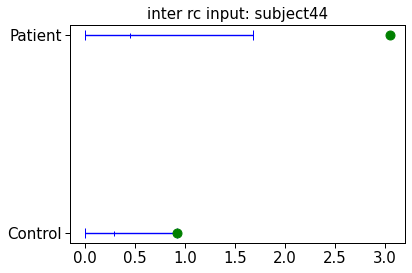

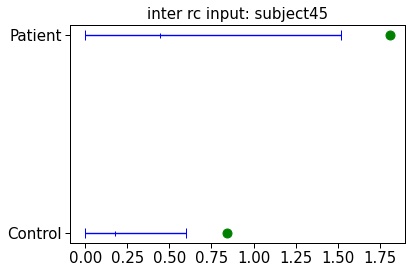

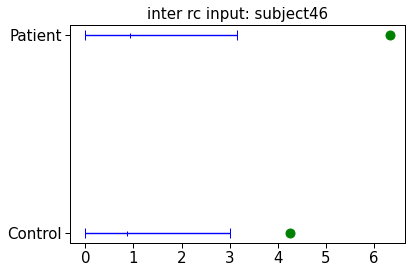

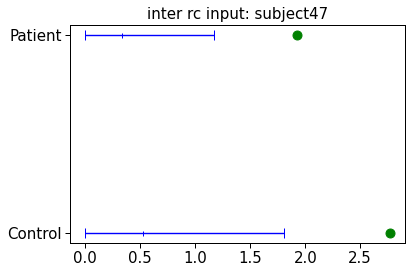

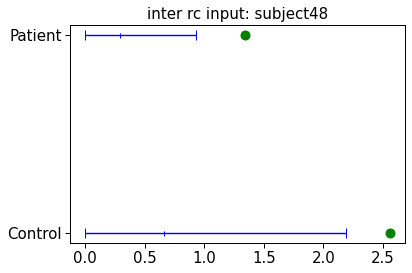

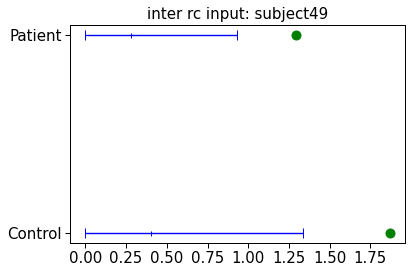

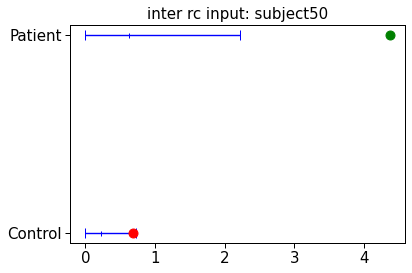

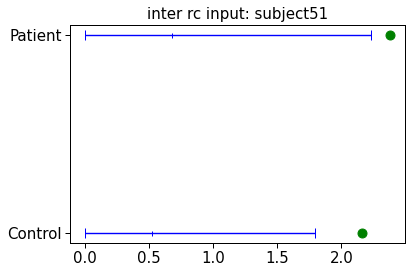

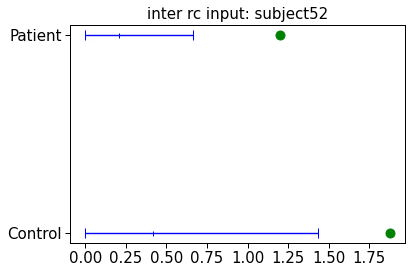

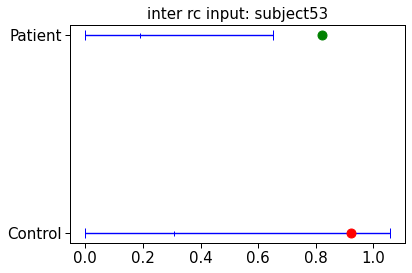

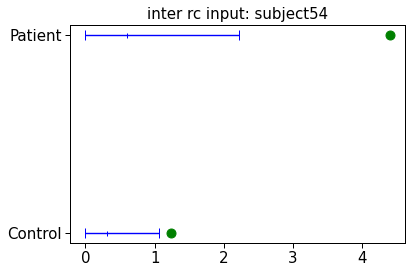

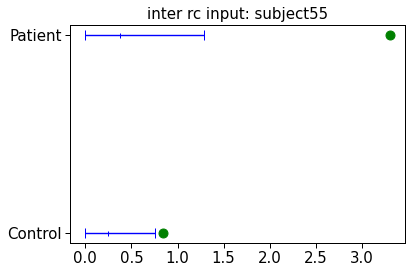

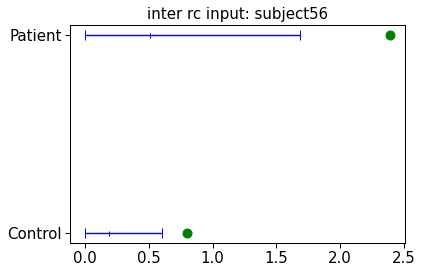

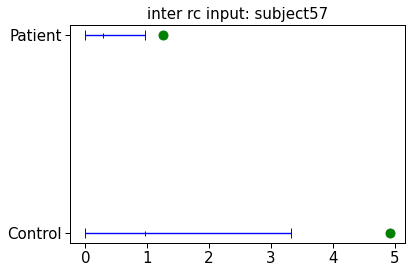

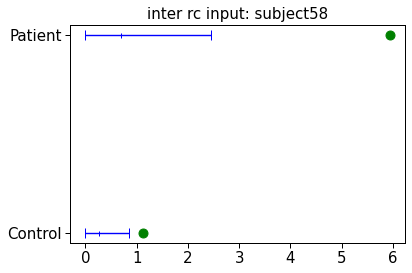

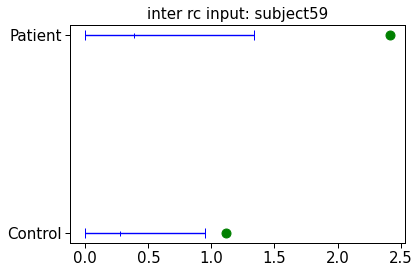

In [35]:
## Examine the patients group.
# Plot CI with marks for the mean and the endpoints
print(black(str('Determine significance of choice of RC regions with respect'
                ' to the inter-rc input:'), 'bold'))
print('The calculations are based on', optimize_with_FC_version, ' with',
      FC_scale, '.')

participant_type_labels = ["Control", "Patient"]
alpha = 0.95 # 95 percentile
lower_limit = int(np.floor(n_samples * (1 - alpha) / 2))
upper_limit = int(np.floor(n_samples * (1 + alpha) / 2))

rankordered_samples = np.sort(inter_sampled_rc_input_patients)
rankordered_samples_p = rankordered_samples[:, lower_limit:upper_limit]
xerr_patients = rankordered_samples_p[:, [0,-1]]

rankordered_samples = np.sort(inter_sampled_rc_input_controls)
rankordered_samples_c = rankordered_samples[:, lower_limit:upper_limit]
xerr_controls = rankordered_samples_c[:, [0,-1]]

fontsize = 15

### Examine the patient group.
## Plot CI with marks for the mean and the endpoints
#fig = plt.figure()
#plt.hlines([1, 1], xmin=xerr_patients[:, 0].mean(),
#           xmax=xerr_patients[:, 1].mean(), color='b')
#plt.plot(xerr_patients.mean(axis=0), [1, 1], '|', color='b', markersize=10)
#plt.plot(rankordered_samples_p.mean(), [1], '|', color='b', markersize=5)
#plt.xticks(fontsize=fontsize)
## Plot RC io ratio (red = not significant, green = significant)
#inter_rc_input = inter_rc_input_patients.mean()
#formatstring = '.r'
#if (inter_rc_input > xerr_patients[:, 1].mean() or
#    inter_rc_input < xerr_patients[:, 0].mean()):
#    formatstring = '.g'
#plt.plot(inter_rc_input, [1], formatstring, markersize=18)
#
### Examine the control group.
## Plot CI with marks for the mean and the endpoints
#plt.hlines([0.5, 0.5], xmin=xerr_controls[:, 0].mean(),
#           xmax=xerr_controls[:, 1].mean(), color='b')
#plt.plot(xerr_controls.mean(axis=0), [0.5, 0.5], '|', color='b', markersize=10)
#plt.plot(rankordered_samples_c.mean(), [0.5], '|', color='b', markersize=5)
#plt.xticks(fontsize=fontsize)
## Plot RC io ratio (red = not significant, green = significant)
#inter_rc_input = inter_rc_input_controls.mean()
#formatstring = '.r'
#if (inter_rc_input > xerr_controls[:, 1].mean() or
#    inter_rc_input < xerr_controls[:, 0].mean()):
#    formatstring = '.g'
#plt.plot(inter_rc_input, [0.5],
#         formatstring, markersize=18)
#plt.title(str('mean inter rc input'), fontsize=fontsize)
#plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
#plt.show()

## Examine the patient group.
# Plot CI with marks for the mean and the endpoints
fig = plt.figure()
plt.hlines([1, 1], xmin=np.median(xerr_patients[:, 0]),
           xmax=np.median(xerr_patients[:, 1]), color='b')
plt.plot(np.median(xerr_patients, axis=0), [1, 1], '|', color='b', markersize=10)
plt.plot(np.median(rankordered_samples_p.mean(axis=1)), [1], '|', color='b', markersize=5)
plt.xticks(fontsize=fontsize)
# Plot RC io ratio (red = not significant, green = significant)
inter_rc_input = np.median(inter_rc_input_patients)
formatstring = '.r'
if (inter_rc_input > np.median(xerr_patients[:, 1]) or
    inter_rc_input < np.median(xerr_patients[:, 0])):
    formatstring = '.g'
plt.plot(inter_rc_input, [1], formatstring, markersize=18)

## Examine the control group.
# Plot CI with marks for the mean and the endpoints
plt.hlines([0.5, 0.5], xmin=np.median(xerr_controls[:, 0]),
           xmax=np.median(xerr_controls[:, 1]), color='b')
plt.plot(np.median(xerr_controls, axis=0), [0.5, 0.5], '|', color='b', markersize=10)
plt.plot(np.median(rankordered_samples_c.mean(axis=1)), [0.5], '|', color='b', markersize=5)
plt.xticks(fontsize=fontsize)
# Plot RC io ratio (red = not significant, green = significant)
inter_rc_input = np.median(inter_rc_input_controls)
formatstring = '.r'
if (inter_rc_input > np.median(xerr_controls[:, 1]) or
    inter_rc_input < np.median(xerr_controls[:, 0])):
    formatstring = '.g'
plt.plot(inter_rc_input, [0.5],
         formatstring, markersize=18)
plt.title(str('median of inter rc input'), fontsize=fontsize)
plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
plt.show()

for i_subject in range(n_subjects):
    # Plot CI with marks for the mean and the endpoints
    fig = plt.figure()
    plt.hlines([1, 1], xmin=xerr_patients[i_subject, 0],
               xmax=xerr_patients[i_subject, 1], color='b')
    plt.plot(xerr_patients[i_subject], [1, 1], '|', color='b', markersize=10)
    plt.plot(rankordered_samples_p[i_subject].mean(), [1], '|', color='b', markersize=5)
    plt.xticks(fontsize=fontsize)
    # Plot RC io ratio (red = not significant, green = significant)
    inter_rc_input = inter_rc_input_patients[i_subject]
    formatstring = '.r'
    if (inter_rc_input > xerr_patients[i_subject, 1] or
        inter_rc_input < xerr_patients[i_subject, 0]):
        formatstring = '.g'
    plt.plot(inter_rc_input, [1], formatstring, markersize=18)

    ## Examine the control group.
    # Plot CI with marks for the mean and the endpoints
    plt.hlines([0.5, 0.5], xmin=xerr_controls[i_subject, 0],
               xmax=xerr_controls[i_subject, 1], color='b')
    plt.plot(xerr_controls[i_subject], [0.5, 0.5], '|', color='b', markersize=10)
    plt.plot(rankordered_samples_c[i_subject].mean(), [0.5], '|', color='b', markersize=5)
    plt.xticks(fontsize=fontsize)
    # Plot RC io ratio (red = not significant, green = significant)
    inter_rc_input = inter_rc_input_controls[i_subject]
    formatstring = '.r'
    if (inter_rc_input > xerr_controls[i_subject, 1] or
        inter_rc_input < xerr_controls[i_subject, 0]):
        formatstring = '.g'
    plt.plot(inter_rc_input, [0.5],
             formatstring, markersize=18)
    plt.title(str('inter rc input: subject' + str(i_subject)), fontsize=fontsize)
    plt.yticks([0.5, 1], participant_type_labels, fontsize=fontsize)
    plt.show()
    #fig.savefig('rc_significant_choice_nodal_degree_FC_avg.png', bbox_inches='tight')